In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import re, os

# plt.rcParams['figure.dpi'] = 200
plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams["font.family"] = "Times New Roman"
MARKERS_LIST = [
    "^",
    "v",
    "s",
    "d",
    "h",
    "p",
    "8",
    "P"
]
COLOR_LIST = [
    # "red",
    # "blue",
    # "green",
    # "#F47F72",
    "#E11F25",
    "#4C8BC0",
    "#456B38",
    "orange",
    "purple",
    "brown",
    "pink",
    "gray"
]

BAR_STYLE_LIST = [ "/" , "\\" , "-" , "+" , "x", "o", "O", ".", "*" ]
LINE_WIDTH=1.5

def export_legend(legend, filename="legend.pdf"):
    fig  = legend.figure
    fig.canvas.draw()
    bbox  = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(filename, dpi="figure", bbox_inches=bbox)
    return

def export_legend_for_labels(marker_list,
                             color_list,
                             label_list,
                             legend_font={"family" : "Monospace"},
                             output_file="legend.pdf"):
    # f = lambda m,c: plt.plot([],[],marker=m, color=c, fillstyle="none", linewidth=LINE_WIDTH)[0]
    f = lambda m,c: plt.plot([],[],marker=m, color=c, fillstyle="none")[0]
    handles = [f(marker_list[i], color_list[i]) for i in range(8)]
    legend_font = {
        # "family" : "Times New Roman",
        # "weight": "bold"
                   "family" : "Monospace",
                }
    legend = plt.legend(handles,
                        label_list,
                        bbox_to_anchor=(1, 1.1),
                        # loc='best',
                        ncol=9,
                        framealpha=1,
                        frameon=False, 
                        prop=legend_font
                        )

    export_legend(legend, output_file)
    # plt.legend().remove()
    plt.show()
    return

def plot_lines(arr_2d, line_labels, x_axis,
               save_path=None,
               marker_list=MARKERS_LIST,
               color_list=COLOR_LIST,
               ms=5,
               x_logscale=False,
               y_logscale=False,
               **kwargs):
    assert len(line_labels) >= len(arr_2d)
    if "fig_size" in kwargs.keys():
        plt.figure(figsize=kwargs["fig_size"])    
    else:
        plt.figure(figsize=(4, 3))
    axes = plt.gca()
    for i in range(len(arr_2d)):
        plt.plot(
            x_axis[:len(arr_2d[i])],
            arr_2d[i],
            marker=marker_list[i],
            color=color_list[i],
            fillstyle="none",
            linewidth=LINE_WIDTH,
            label=line_labels[i],
            markersize=ms
        )
    if x_logscale:
        if "x_logbase" in kwargs.keys():
            axes.set_xscale("log", base=kwargs["x_logbase"])
        else:
            axes.set_xscale("log")
    if y_logscale:
        if "y_logbase" in kwargs.keys():
            axes.set_yscale("log", base=kwargs["y_logbase"])
        else:
            axes.set_yscale("log")
    plt.xticks(x_axis)
    if "tick_size" in kwargs.keys():
        # axes.set_xticks(x_axis, fontsize=kwargs["tick_size"])
        # axes.set_yticks(fontsize=kwargs["tick_size"])
        axes.tick_params(labelsize=kwargs["tick_size"])
    if "x_ticks" in kwargs.keys():
        axes.set_xticks(kwargs["x_ticks"])
        if "x_ticklabels" in kwargs.keys():
            axes.set_xticklabels(kwargs["x_ticklabels"])
    if "y_ticks" in kwargs.keys():
        axes.set_yticks(kwargs["y_ticks"])
        if "y_ticklabels" in kwargs.keys():
            axes.set_yticklabels(kwargs["y_ticklabels"])
    if "minor_ticks" in kwargs.keys() and kwargs["minor_ticks"] == False:
        axes.minorticks_off()
    if "x_label" in kwargs.keys():
        plt.xlabel(kwargs["x_label"],
                   fontstyle="italic",
                   fontsize=13)
    if "y_label" in kwargs.keys():
        plt.ylabel(kwargs["y_label"],
                   fontsize=13,
                   fontstyle="italic",
                   labelpad=20,
                   rotation=0,
                   ha='left', va='center'
                   )
        axes.yaxis.set_label_coords(-0.2, 1.1)
    
    if "y_label_pos" in kwargs.keys():
        axes.yaxis.set_label_coords(kwargs["y_label_pos"][0], kwargs["y_label_pos"][1])
    
    if "label_size" in kwargs.keys():
        axes.yaxis.label.set_size(kwargs["label_size"])
        axes.xaxis.label.set_size(kwargs["label_size"])
            
    if "y_lim" in kwargs.keys():
        axes.set_ylim(kwargs["y_lim"])
        
    if "title" in kwargs.keys():
        plt.title(kwargs["title"])
    axes.tick_params(which="both", direction="in")
    if "tick_pad" in kwargs.keys():
        axes.tick_params(pad=kwargs["tick_pad"])
    if "display_legend" in kwargs.keys() and kwargs["display_legend"]:
        plt.legend()
    plt.tight_layout()
    if save_path != None:
        dir = os.path.split(save_path)[0]
        os.makedirs(dir, exist_ok=True)
        plt.savefig(save_path)
    plt.show()
    return

def plot_stacked_bar(data, x_axis, labels, **kwargs):
    assert(len(data) == len(x_axis))
    if "fig_size" in kwargs.keys():
        plt.figure(figsize=kwargs["fig_size"])    
    else:
        plt.figure(figsize=(4, 3))
    axes = plt.gca()
    data = np.array(data).T
    bottom = np.zeros(len(x_axis))
    for i in range(len(data)):
        p = axes.bar(x_axis, data[i], 0.5, label=labels, bottom=bottom, hatch=BAR_STYLE_LIST[i])
        bottom += data[i]
        
    if "x_logscale" in kwargs.keys() and kwargs["x_logscale"]:
        if "x_logbase" in kwargs.keys():
            axes.set_xscale("log", base=kwargs["x_logbase"])
        else:
            axes.set_xscale("log")
    if "y_logscale" in kwargs.keys() and kwargs["y_logscale"]:
        if "y_logbase" in kwargs.keys():
            axes.set_yscale("log", base=kwargs["y_logbase"])
        else:
            axes.set_yscale("log")
    plt.show()
    
MARKER_SIZE=15
LABEL_SIZE=20
Y_LABEL_POS=[0, 1.1]
TICK_SIZE=18
FIG_SIZE=[4, 3.5]

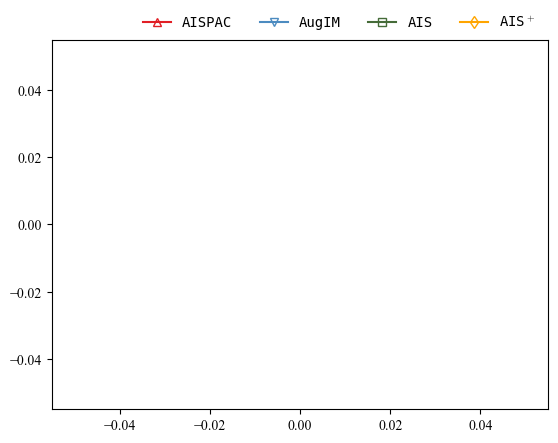

In [86]:
export_legend_for_labels(MARKERS_LIST, COLOR_LIST, label_list=["AISPAC", "AugIM", "AIS", r"AIS$^+$"], output_file="./figs/legend.pdf")

In [17]:
test = pd.read_csv(os.path.join(f"./data/nethept/params/50_10000_0.500000_0.001000_2023_RANDseed_WC/", "k_inf_spread_MCGreedy_1000.csv"))["expected spread"]
test.iloc[-1]

# Read data from files

In [3]:
BASELINE_NAMES = ["RAND", "OUTDEG", "PROB", "SINF", "UINF", "AIS-U" , "IMA"]
NUM_RR = np.array([100, 200, 400, 800, 1600, 3200, 6400, 12800, 25600, 51200, 102400])
RAND_SEEDS = [2021, 2022, 2023, 2024, 2025, 2026]
K_LIST = [5, 10, 20, 30, 40, 50]
EPS_LIST = ["0.1", "0.2", "0.3", "0.4", "0.5"]
BETA_LIST = [1, 2, 4, 8, 16, 32, 64]
rand_seeds_nethept = [42, 2020, 2022, 2023, 2024]
TIME_LABELS = ["RR sets", "Sampling Stage 2", "Selection"]

def get_inf_from_csv(filepath):
    df = pd.read_csv(filepath)
    return float(df["expected spread"].iloc[-1])

def get_inf_from_csv_one_method(dataset:str, method:str):
    res = []
    for i, rand_seed in enumerate(range(2021, 2026)):
        res_for_diff_seeds = []
        for k_edge in [5, 10, 20, 30, 40, 50]:
            folder_path = f"./data/{dataset}/params/{k_edge}_0_0.500000_0.001000_{rand_seed}_WC/"
            csv_filename = os.path.join(folder_path, f"k_inf_spread_{method}.csv")
            res_for_diff_seeds.append(get_inf_from_csv(csv_filename))
        res.append(res_for_diff_seeds)
    res = np.mean(np.array(res), axis=0)
    return res

def get_res_from_file(file_path, mode="result")->float:
    with open(file_path, 'r') as file:
        match = None
        for line in file:
            if mode == "result" and line.startswith('Result by'):
                match = re.search(r'\d+(\.\d+)?', line)
            elif mode == "origin" and line.startswith("Original Inf:"):
                match = re.search(r'\d+(\.\d+)?', line)
            
        if match:
            number = float(match.group())
            return number
        else:
            print("RESULT NOT FOUND", file_path)

def get_RRset_generation_time(file_path):
    with open(file_path, "r") as file:
        contents = file.read()

        # Use regular expressions to extract the RR set generation time
        pattern = r"->Time used \(sec\) for operation \[RR set generation\]: (\d+\.\d+|\d+)"
        match = re.search(pattern, contents)

        if match:
            rr_set_time = float(match.group(1))
            return rr_set_time
        else:
            print("RR set generation time not found")
            return -1.0

def get_process_time(file_path):
    with open(file_path, "r") as file:
        # Read the contents of the file
        contents = file.read()

        # Use regular expressions to find the line with the keyword "process"
        pattern = r".*process.*"
        match = re.search(pattern, contents, re.MULTILINE)

        if match:
            line = match.group(0)
            # Use regular expressions to extract the running time from the line
            time_pattern = r"\d+(\.\d+)?"
            time_match = re.search(time_pattern, line)
            if time_match:
                running_time = float(time_match.group(0))
                return running_time
            else:
                print("Running time not found in the line with the keyword 'process'")
        else:
            print("Line with the keyword 'process' not found")

def get_original_inf(dataset_name:str, rand_seeds):
    res_arr = []
    for rand_seed in rand_seeds:
        path = f"./data/{dataset_name}/params/5_0_0.500000_0.001000_{rand_seed}_WC/log_IMA.txt"
        res_arr.append(get_res_from_file(path, "origin"))
    return sum(res_arr) / len(res_arr)

def get_inf_beta_of_one_dataset(dataset_name:str, rand_seeds, baseline_names=["IMA"], k_edges=50):
    res = {}
    for baseline in baseline_names:
        inf_diff_rand_seed_list = []
        for rand_seed in rand_seeds:
            inf_for_one_rand_seed = []
            for beta in BETA_LIST:
                try:
                    if beta == 1:
                        path = f"./data/{dataset_name}/params/{k_edges}_0_0.500000_0.001000_{rand_seed}_WC/log_{baseline}.txt"
                    else:
                        path = f"./data/{dataset_name}/params/{k_edges}_0_0.500000_0.001000_{rand_seed}_WC_beta_{beta}/log_{baseline}.txt"
                    # print(path)
                    inf_for_one_rand_seed.append(get_res_from_file(path, "result"))
                except:
                    print(path)
            inf_diff_rand_seed_list.append(inf_for_one_rand_seed)
        
        x_mean = np.mean(np.array(inf_diff_rand_seed_list), axis=0)
        res[baseline] = x_mean / np.max(x_mean)
        # res[baseline] = np.mean(np.array(inf_diff_rand_seed_list), axis=0)
    return res

def get_time_beta_of_one_dataset(dataset_name:str, rand_seeds, baseline_names=["IMA"], k_edges=50):
    res = {}
    for baseline in baseline_names:
        time_diff_rand_seed_list = []
        for rand_seed in rand_seeds:
            time_for_one_rand_seed = []
            for beta in BETA_LIST:
                try:
                    if beta == 1:
                        working_folder = f"./data/{dataset_name}/params/{k_edges}_0_0.500000_0.001000_{rand_seed}_WC/"
                    else:
                        working_folder = f"./data/{dataset_name}/params/{k_edges}_0_0.500000_0.001000_{rand_seed}_WC_beta_{beta}/"
                    
                    log_path = os.path.join(working_folder, "logs.txt")
                    log_baseline_path = os.path.join(working_folder, f"log_{baseline}.txt")
                    RR_set_gen_time = get_RRset_generation_time(log_path)
                    process_time = get_process_time(log_baseline_path)
                    time_for_one_rand_seed.append(RR_set_gen_time + process_time)
                except Exception as e:
                    print(e.args)
                    print(baseline, rand_seed, k_edges)
                    print(working_folder)
            time_diff_rand_seed_list.append(time_for_one_rand_seed)
        
        res[baseline] = np.mean(np.array(time_diff_rand_seed_list), axis=0)
    return res

def get_inf_spread_of_one_dataset(dataset_name:str, rand_seeds, k_list=K_LIST, baseline_names=["AIS"], settings:dict={"eps":0.1, "seed_mode":"RAND"}):
    res = {}
    s_eps = format(settings["eps"], '.6f')
    seed_mode = settings["seed_mode"] if "seed_mode" in settings.keys() else "IM"
    num_samples = settings["num_samples"] if "num_samples" in settings.keys() else 0
    k = settings["k_edges"] if "k_edges" in settings.keys() else 50
    if num_samples > 0:
        s_eps = "0.000000"
    for baseline in baseline_names:
        inf_diff_rand_seed_list = []
        for rand_seed in rand_seeds:
            inf_for_one_rand_seed = []
            for k_edges in k_list:
                try:
                    dir_name = f"./data/{dataset_name}/params/{k_edges}_0_{s_eps}_0.001000_{rand_seed}_WC"
                    if seed_mode != "IM":
                        dir_name = f"./data/{dataset_name}/params/{k_edges}_0_{s_eps}_0.001000_{rand_seed}_{seed_mode}seed_WC"
                    if num_samples != 0:
                        dir_name = dir_name + f"_numsamples_{num_samples}"
                    path = os.path.join(dir_name, f"k_inf_spread_{baseline}.csv")
                    # print(path)
                    inf_for_one_rand_seed.append(get_inf_from_csv(path))
                except:
                    print(baseline, rand_seed, k_edges)
                    print(path)
            inf_diff_rand_seed_list.append(inf_for_one_rand_seed)
        res[baseline] = np.mean(np.array(inf_diff_rand_seed_list), axis=0)
    return res

def get_eps_inf_of_one_dataset(dataset_name:str, rand_seeds, baseline_names=["IMA"], k_edges=50):
    res = {}
    
    for baseline in baseline_names:
        inf_diff_rand_seed_list = []
        for rand_seed in rand_seeds:
            inf_for_one_rand_seed = []
            for eps in EPS_LIST:
                try:
                    path = f"./data/{dataset_name}/params/{k_edges}_0_{eps}00000_0.001000_{rand_seed}_WC/log_{baseline}.txt"
                    # print(path)
                    inf_for_one_rand_seed.append(get_res_from_file(path, "result"))
                except:
                    print(path)
            inf_diff_rand_seed_list.append(inf_for_one_rand_seed)
        x_mean = np.mean(np.array(inf_diff_rand_seed_list), axis=0)
        res[baseline] = x_mean / np.max(x_mean)
    return res

def get_eps_time_of_one_dataset(dataset_name:str, rand_seeds, baseline_names=["IMA"]):
    res = {}
    for baseline in baseline_names:
        time_diff_rand_seed_list = []
        for rand_seed in rand_seeds:
            time_for_one_rand_seed = []
            for eps in EPS_LIST:
                try:
                    working_folder = f"./data/{dataset_name}/params/50_0_{eps}00000_0.001000_{rand_seed}_WC/"
                    log_path = os.path.join(working_folder, "logs.txt")
                    log_baseline_path = os.path.join(working_folder, f"log_{baseline}.txt")
                    RR_set_gen_time = get_RRset_generation_time(log_path)
                    process_time = get_process_time(log_baseline_path)
                    time_for_one_rand_seed.append(RR_set_gen_time + process_time)
                except Exception as e:
                    print(e.args)
                    print(working_folder)
            time_diff_rand_seed_list.append(time_for_one_rand_seed)
        res[baseline] = np.mean(np.array(time_diff_rand_seed_list), axis=0)
    return res

def get_runtime_of_one_dataset(dataset_name:str, rand_seeds, baseline_names=["SINF", "UINF", "AIS-U" , "IMA"], k_list=K_LIST, seed_mode="IM",
                               num_cand_edges=0):
    res = {}
    for baseline in baseline_names:
        time_diff_rand_seed_list = []
        for rand_seed in rand_seeds:
            time_for_one_rand_seed = []
            for k_edges in k_list:
                try:
                    working_folder = f"./data/{dataset_name}/params/{k_edges}_{num_cand_edges}_0.500000_0.001000_{rand_seed}_WC/"
                    if seed_mode == "RAND":
                        working_folder = f"./data/{dataset_name}/params/{k_edges}_{num_cand_edges}_0.500000_0.001000_{rand_seed}_RANDseed_WC/"
                        
                    log_path = os.path.join(working_folder, "logs.txt")
                    if baseline == "AISPAC":
                        log_path = os.path.join(working_folder, "logs_for_AISPAC.txt")
                    log_baseline_path = os.path.join(working_folder, f"log_{baseline}.txt")
                    RR_set_gen_time = get_RRset_generation_time(log_path)
                    process_time = get_process_time(log_baseline_path)
                    if baseline in ["SINF", "UINF", "AIS-U" , "IMA"]:
                        time_for_one_rand_seed.append(RR_set_gen_time + process_time)
                    else:
                        time_for_one_rand_seed.append(process_time)
                except Exception as e:
                    print(e.args)
                    print(working_folder)
            time_diff_rand_seed_list.append(time_for_one_rand_seed)
        res[baseline] = np.mean(np.array(time_diff_rand_seed_list), axis=0)
    return res

def get_runtime_k_mcg(dataset_name:str, rand_seeds:list, k_list=K_LIST, seed_mode="RAND", num_cand_edges=10000):
    res = {}

    time_diff_rand_seed_list = []
    for rand_seed in rand_seeds:
        time_for_one_rand_seed = []
        try:
            working_folder = f"./data/{dataset_name}/params/50_{num_cand_edges}_0.500000_0.001000_{rand_seed}_WC/"
            if seed_mode == "RAND":
                working_folder = f"./data/{dataset_name}/params/50_{num_cand_edges}_0.500000_0.001000_{rand_seed}_RANDseed_WC/"
            log_path = os.path.join(working_folder, "MCGreedy_10000_time.txt")
            with open(log_path, 'r') as f:
                contents = f.read()
                for k_edges in k_list:
                    pattern = r"\[select_" + str(k_edges) + r"\]:\s+(\d+(\.\d+)?)"
                    match = re.search(pattern, contents)
                    time_for_one_rand_seed.append(float(match.group(1)))
        except Exception as e:
            print(e.args)
            print(working_folder)
        time_diff_rand_seed_list.append(time_for_one_rand_seed)
        res["MCGreedy"] = np.mean(np.array(time_diff_rand_seed_list), axis=0)
    return res

def get_runtime_r_mcg(dataset_name:str, rand_seeds:list, r_list=[2000, 4000, 6000, 8000, 10000], seed_mode="RAND", num_cand_edges=10000):
    res = {}

    time_diff_rand_seed_list = []
    for rand_seed in rand_seeds:
        time_for_one_rand_seed = []
        try:
            working_folder = f"./data/{dataset_name}/params/50_{num_cand_edges}_0.500000_0.001000_{rand_seed}_WC/"
            if seed_mode == "RAND":
                working_folder = f"./data/{dataset_name}/params/50_{num_cand_edges}_0.500000_0.001000_{rand_seed}_RANDseed_WC/"
            for r in r_list:
                log_path = os.path.join(working_folder, f"MCGreedy_{str(r)}_time.txt")
                with open(log_path, 'r') as f:
                    contents = f.read()
                    pattern = r"\[select_50\]:\s+(\d+(\.\d+)?)"
                    match = re.search(pattern, contents)
                    time_for_one_rand_seed.append(float(match.group(1)))
        except Exception as e:
            print(e.args)
            print(working_folder)
            print(r)
        time_diff_rand_seed_list.append(time_for_one_rand_seed)
        res["MCGreedy"] = np.mean(np.array(time_diff_rand_seed_list), axis=0)
    return res


def display_for_tex(method_inf_dict, method="IMA", k_list = [0, 5, 10, 20, 30, 40, 50]):
    for i in range(len(method_inf_dict[method])):
        print(f"({k_list[i]},{round(method_inf_dict[method][i], 4)})")

def display_for_tex_all(method_inf_dict, k_list = [0, 5, 10, 20, 30, 40, 50]):
    for method in method_inf_dict.keys():
        print(method + ":")
        display_for_tex(method_inf_dict, method, k_list)
        
def get_inf_numRRsets_of_one_dataset(dataset_name:str, rand_seeds, baseline_names=["IMA"],
                                     settings={"seed_mode":"RAND", "k_edges":50}):
    res = {}
    seed_mode = settings["seed_mode"] if "seed_mode" in settings.keys() else "IM"
    k_edges = settings["k_edges"] if "k_edges" in settings.keys() else 50
    for baseline in baseline_names:
        inf_diff_rand_seed_list = []
        for rand_seed in rand_seeds:
            inf_for_one_rand_seed = []
            for num_samples in NUM_RR:
                try:
                    if seed_mode != "IM":
                        path = f"./data/{dataset_name}/params/{k_edges}_0_0.000000_0.001000_{rand_seed}_{seed_mode}seed_WC_numsamples_{num_samples}/k_inf_spread_{baseline}.csv"
                    else:
                        path = f"./data/{dataset_name}/params/{k_edges}_0_0.000000_0.001000_{rand_seed}_WC_numsamples_{num_samples}/k_inf_spread_{baseline}.csv"
                    # print(path)
                    inf_for_one_rand_seed.append(get_inf_from_csv(path))
                except:
                    print(baseline, rand_seed)
                    print(path)
            inf_diff_rand_seed_list.append(inf_for_one_rand_seed)
        res[baseline] = np.mean(np.array(inf_diff_rand_seed_list), axis=0)
    return res


def get_sep_runtime_one_file(filepath):
    # Regular expressions to match the time values
    sampling_time_pattern = r"Sampling Time \(sec\): (\d+\.*\d*)"
    sampling_phase_2_time_pattern = r"Sampling Phase 2 Time \(sec\): (\d+\.*\d*)"
    selection_time_pattern = r"Selection Time \(sec\): (\d+\.*\d*)"

    # Extracting the time values
    with open(filepath, 'r') as f:
        file_content = f.read()
        sampling_time = re.search(sampling_time_pattern, file_content).group(1)
        sampling_phase_2_time = re.search(sampling_phase_2_time_pattern, file_content).group(1)
        selection_time = re.search(selection_time_pattern, file_content).group(1)

    # Storing the time values in a list
    time_values = [float(sampling_time), float(sampling_phase_2_time), float(selection_time)]
    return time_values


def get_runtime_for_bar_of_one_dataset(dataset_name:str, rand_seeds, baseline_names=["AIS"], settings:dict={"eps":0.1, "seed_mode":"RAND"}):
    res = {}
    s_eps = format(settings["eps"], '.6f')
    seed_mode = settings["seed_mode"] if "seed_mode" in settings.keys() else "IM"
    num_samples = settings["num_samples"] if "num_samples" in settings.keys() else 0
    k_edges = settings["k_edges"] if "k_edges" in settings.keys() else 50
    if num_samples > 0:
        s_eps = "0.000000"
    for baseline in baseline_names:
        time_diff_rand_seed_list = []
        for rand_seed in rand_seeds:
            try:
                dir_name = f"./data/{dataset_name}/params/{k_edges}_0_{s_eps}_0.001000_{rand_seed}_WC"
                if seed_mode != "IM":
                    dir_name = f"./data/{dataset_name}/params/{k_edges}_0_{s_eps}_0.001000_{rand_seed}_{seed_mode}seed_WC"
                if num_samples != 0:
                    dir_name = dir_name + f"_numsamples_{num_samples}"
                path = os.path.join(dir_name, f"log_{baseline}.txt")
                # print(path)
                time_for_one_rand_seed = get_sep_runtime_one_file(path)
            except:
                print(baseline, rand_seed, k_edges)
                print(path)
            time_diff_rand_seed_list.append(time_for_one_rand_seed)
        res[baseline] = np.mean(np.array(time_diff_rand_seed_list), axis=0)
    return res

def get_runtime_for_lines_of_one_dataset(dataset_name:str, rand_seeds, baseline_names=["AIS"], k_list=K_LIST, settings:dict={"eps":0.1, "seed_mode":"RAND"}):
    res = {}
    s_eps = format(settings["eps"], '.6f')
    seed_mode = settings["seed_mode"] if "seed_mode" in settings.keys() else "IM"
    num_samples = settings["num_samples"] if "num_samples" in settings.keys() else 0
    k_edges = settings["k_edges"] if "k_edges" in settings.keys() else 50
    if num_samples > 0:
        s_eps = "0.000000"
        
    for baseline in baseline_names:
        time_diff_rand_seed_list = []
        for rand_seed in rand_seeds:
            time_for_one_rand_seed = []
            for k in k_list:
                try:
                    dir_name = f"./data/{dataset_name}/params/{k}_0_{s_eps}_0.001000_{rand_seed}_WC"
                    if seed_mode != "IM":
                        dir_name = f"./data/{dataset_name}/params/{k}_0_{s_eps}_0.001000_{rand_seed}_{seed_mode}seed_WC"
                    if num_samples != 0:
                        dir_name = dir_name + f"_numsamples_{num_samples}"
                    path = os.path.join(dir_name, f"log_{baseline}.txt")
                    # print(path)
                    time_for_one_rand_seed.append(sum(get_sep_runtime_one_file(path)))
                except:
                    print(baseline, rand_seed, k_edges)
                    print(path)
                time_diff_rand_seed_list.append(time_for_one_rand_seed)
        res[baseline] = np.mean(np.array(time_diff_rand_seed_list), axis=0)
    return res

def convert_dict_to_arr(method_data_dict:dict, method_list):
    res = []
    for method in method_list:
        res.append(method_data_dict[method])
    return np.array(res)


In [16]:
sep_time_epin = get_runtime_for_bar_of_one_dataset("Epinions", RAND_SEEDS, ["AIS", "AISPAC", "AugIM"], {"eps":0, "seed_mode":"RAND", "num_samples":102400})
sep_time_dblp = get_runtime_for_bar_of_one_dataset("DBLP", RAND_SEEDS, ["AIS", "AISPAC", "AugIM"], {"eps":0, "seed_mode":"RAND", "num_samples":102400})
sep_time_orkut = get_runtime_for_bar_of_one_dataset("orkut", RAND_SEEDS, ["AIS", "AISPAC", "AugIM"], {"eps":0, "seed_mode":"RAND", "num_samples":102400})
sep_time_LJ = get_runtime_for_bar_of_one_dataset("LJ", RAND_SEEDS, ["AIS", "AISPAC", "AugIM"], {"eps":0, "seed_mode":"RAND", "num_samples":102400})
sep_time_twitter = get_runtime_for_bar_of_one_dataset("twitter", RAND_SEEDS, ["AIS", "AISPAC", "AugIM"], {"eps":0, "seed_mode":"RAND", "num_samples":102400})

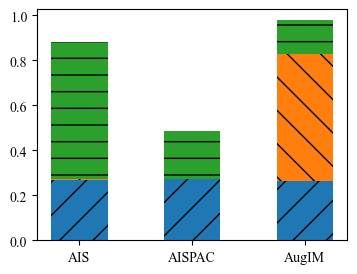

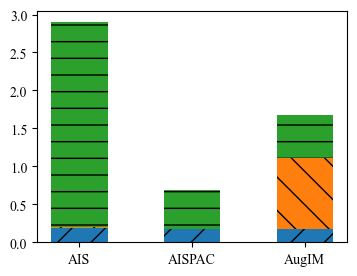

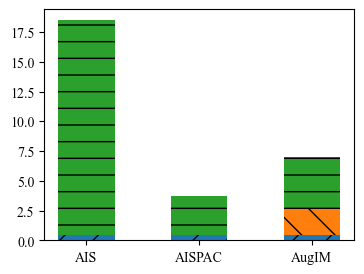

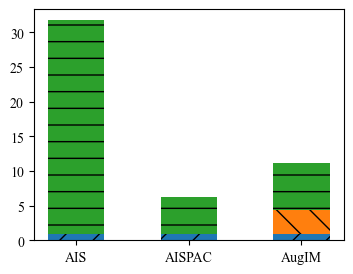

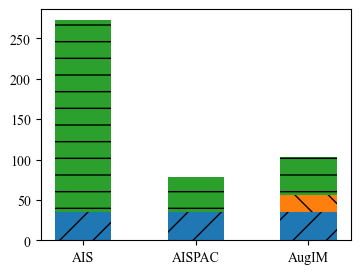

In [27]:
plot_stacked_bar(list(sep_time_epin.values()), list(sep_time_epin.keys()), TIME_LABELS,)
plot_stacked_bar(list(sep_time_dblp.values()), list(sep_time_epin.keys()), TIME_LABELS,)
plot_stacked_bar(list(sep_time_orkut.values()), list(sep_time_epin.keys()), TIME_LABELS,)
plot_stacked_bar(list(sep_time_LJ.values()), list(sep_time_epin.keys()), TIME_LABELS,)
plot_stacked_bar(list(sep_time_twitter.values()), list(sep_time_epin.keys()), TIME_LABELS)

# Preserving the Guarantee

In [7]:
inf_k_epin_dict = get_inf_spread_of_one_dataset("Epinions", list(range(2021, 2025))+list(range(2031, 2036)),
                                                baseline_names=["AISPAC", "AugIM", "AIS", "AIS_plus"],
                                                settings={"eps":0.1, "seed_mode":"OUTDEG"})
inf_k_epin_arr = np.array(list(inf_k_epin_dict.values()))
inf_k_dblp_dict = get_inf_spread_of_one_dataset("DBLP", list(range(2021, 2031)), 
                                                baseline_names=["AISPAC", "AugIM", "AIS", "AIS_plus"],
                                                settings={"eps":0.1, "seed_mode":"OUTDEG"})
inf_k_dblp_arr = np.array(list(inf_k_dblp_dict.values()))
# inf_k_orkut_dict = get_inf_spread_of_one_dataset("orkut", list(range(2021, 2032)), ["AISPAC", "AugIM", "AIS"],
#                                                 {"eps":0.1, "seed_mode":"OUTDEG"})
# inf_k_orkut_arr = np.array(list(inf_k_orkut_dict.values()))

dict_keys(['AISPAC', 'AugIM', 'AIS', 'AIS_plus'])

In [29]:
inf_k_dblp_arr

array([[25823.11, 28408.73, 32140.36, 34926.28, 37045.76, 38726.21],
       [25819.38, 28385.45, 31968.63, 34510.09, 36418.3 , 38143.43],
       [25841.64, 28438.58, 32223.61, 35086.25, 37186.7 , 38992.97],
       [25841.64, 28438.58, 32223.61, 35086.25, 37186.7 , 38992.97]])

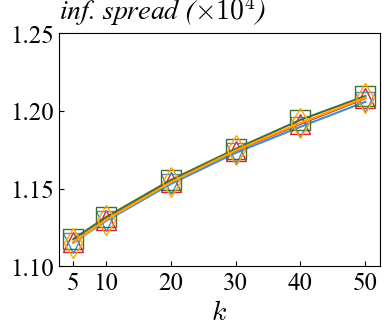

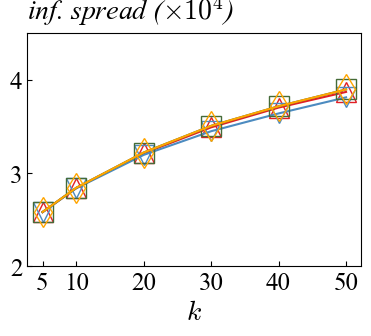

In [72]:
plot_lines(inf_k_epin_arr / 10000,
           line_labels=["AISPAC", "AugIM", "AIS", "AIS_plus"],
           x_axis=K_LIST,
           ms=MARKER_SIZE,
           x_label=r"$k$",
           y_label=r"inf. spread ($\times 10^4$)",
           tick_size=TICK_SIZE,
           label_size=LABEL_SIZE,
           fig_size=FIG_SIZE,
           y_label_pos=Y_LABEL_POS,
           y_lim = [1.1, 1.25],
           save_path="./figs/inf_k_OUTDEG_epin.pdf"
           )
plot_lines(inf_k_dblp_arr / 10000,
           line_labels=["AISPAC", "AugIM", "AIS", "AIS_plus"],
           x_axis=K_LIST,
           ms=MARKER_SIZE,
           x_label=r"$k$",
           y_label=r"inf. spread ($\times 10^4$)",
           tick_size=TICK_SIZE,
           label_size=LABEL_SIZE,
           fig_size=FIG_SIZE,
           y_label_pos=Y_LABEL_POS,
           y_lim = [2,4.5],
           save_path="./figs/inf_k_OUTDEG_dblp.pdf"
           )

# plot_lines(inf_k_orkut_arr / 10000,
#            line_labels=["AISPAC", "AugIM", "AIS"],
#            x_axis=K_LIST,
#            ms=MARKER_SIZE,
#            x_label=r"$k$",
#            y_label=r"inf. spread ($\times 10^4$)",
#            tick_size=TICK_SIZE,
#            label_size=LABEL_SIZE,
#            fig_size=FIG_SIZE,
#            y_label_pos=[-0.1, 1.1],
#         #    y_lim = [0,4.5],
#            save_path="./figs/inf_k_OUTDEG_orkut.pdf"
#            )

In [43]:
time_k_epin = get_runtime_for_lines_of_one_dataset("Epinions", list(range(2021, 2031)), 
                                                   baseline_names=["AISPAC", "AugIM", "AIS", "AIS_plus"],
                                                   settings={"eps":0.1, "seed_mode":"OUTDEG"})
time_k_epin_arr = np.array(list(time_k_epin.values()))
time_k_dblp = get_runtime_for_lines_of_one_dataset("DBLP", list(range(2021, 2031)),
                                                   baseline_names=["AISPAC", "AugIM", "AIS", "AIS_plus"],
                                                   settings={"eps":0.1, "seed_mode":"OUTDEG"})
time_k_dblp_arr = np.array(list(time_k_dblp.values()))

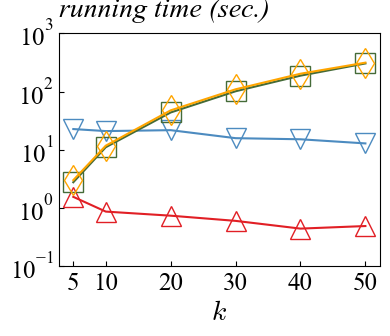

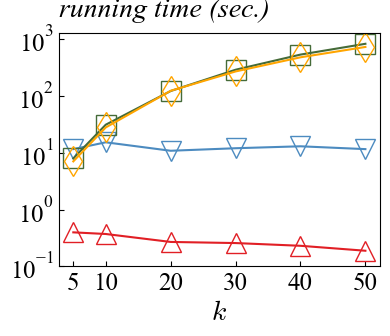

In [44]:
plot_lines(time_k_epin_arr,
           line_labels=["AISPAC", "AugIM", "AIS", "AIS_plus"],
           x_axis=K_LIST,
           ms=MARKER_SIZE,
           x_label=r"$k$",
           y_label=r"running time (sec.)",
           tick_size=TICK_SIZE,
           label_size=LABEL_SIZE,
           fig_size=FIG_SIZE,
           y_label_pos=Y_LABEL_POS,
           y_logscale=True,
           y_ticks=[0.1, 1, 10, 100, 1000],
           minor_ticks=False,
           save_path="./figs/time_k_OUTDEG_epin.pdf"
           )
plot_lines(time_k_dblp_arr,
           line_labels=["AISPAC", "AugIM", "AIS", "AIS_plus"],
           x_axis=K_LIST,
           ms=MARKER_SIZE,
           x_label=r"$k$",
           y_label=r"running time (sec.)",
           tick_size=TICK_SIZE,
           label_size=LABEL_SIZE,
           fig_size=FIG_SIZE,
           y_label_pos=Y_LABEL_POS,
           y_logscale=True,
           y_ticks=[0.1, 1, 10, 100, 1000],
           
           save_path="./figs/time_k_OUTDEG_dblp.pdf"
           )

# Scalability

In [5]:
all_methods = ["AISPAC", "AugIM", "AIS", "AIS_plus"]
scale_k_list = [5, 10] + list(range(20, 101, 20))
methods_approx = ["AISPAC", "AugIM"]
methods_ais = ["AIS", "AIS_plus"]


In [9]:
inf_k_Epinions_scale_dict = get_inf_spread_of_one_dataset("Epinions", list(range(2021, 2031)),
                                                k_list=scale_k_list,
                                                baseline_names=methods_approx,
                                                settings={"eps":0.1, "seed_mode":"RAND"})
inf_k_Epinions_scale_dict_AIS = get_inf_spread_of_one_dataset("Epinions", list(range(2021, 2031)),
                                                k_list=scale_k_list,
                                                baseline_names=methods_ais,
                                                settings={"eps":0, "seed_mode":"RAND", "num_samples":102400})
inf_k_Epinions_scale_arr = convert_dict_to_arr({**inf_k_Epinions_scale_dict, **inf_k_Epinions_scale_dict_AIS}, all_methods)

inf_k_DBLP_scale_dict = get_inf_spread_of_one_dataset("DBLP", list(range(2021, 2026)),
                                                k_list=scale_k_list,
                                                baseline_names=methods_approx,
                                                settings={"eps":0.1, "seed_mode":"RAND"})
inf_k_DBLP_scale_dict_AIS = get_inf_spread_of_one_dataset("DBLP", list(range(2021, 2026)),
                                                k_list=scale_k_list,
                                                baseline_names=methods_ais,
                                                settings={"eps":0, "seed_mode":"RAND", "num_samples":102400})
inf_k_DBLP_scale_arr = convert_dict_to_arr({**inf_k_DBLP_scale_dict, **inf_k_DBLP_scale_dict_AIS}, all_methods)

inf_k_LJ_scale_dict = get_inf_spread_of_one_dataset("LJ", list(range(2021, 2031)),
                                                k_list=scale_k_list,
                                                baseline_names=methods_approx,
                                                settings={"eps":0.1, "seed_mode":"RAND"})
inf_k_LJ_scale_dict_AIS = get_inf_spread_of_one_dataset("LJ", list(range(2021, 2031)),
                                                k_list=scale_k_list,
                                                baseline_names=methods_ais,
                                                settings={"eps":0, "seed_mode":"RAND", "num_samples":102400})
inf_k_LJ_scale_arr = convert_dict_to_arr({**inf_k_LJ_scale_dict, **inf_k_LJ_scale_dict_AIS}, all_methods)

inf_k_orkut_scale_dict = get_inf_spread_of_one_dataset("orkut", list(range(2021, 2031)),
                                                k_list=scale_k_list,
                                                baseline_names=methods_approx,
                                                settings={"eps":0.1, "seed_mode":"RAND"})
inf_k_orkut_scale_dict_AIS = get_inf_spread_of_one_dataset("orkut", list(range(2021, 2031)),
                                                k_list=scale_k_list,
                                                baseline_names=methods_ais,
                                                settings={"eps":0, "seed_mode":"RAND", "num_samples":102400})
inf_k_orkut_scale_arr = convert_dict_to_arr({**inf_k_orkut_scale_dict, **inf_k_orkut_scale_dict_AIS}, all_methods)

# inf_k_twitter_scale_dict = get_inf_spread_of_one_dataset("twitter", list(range(2021, 2024)),
#                                                 k_list=scale_k_list,
#                                                 baseline_names=methods_approx,
#                                                 settings={"eps":0.1, "seed_mode":"RAND"})
# inf_k_twitter_scale_dict_AIS = get_inf_spread_of_one_dataset("twitter", list(range(2021, 2024)),
#                                                 k_list=scale_k_list,
#                                                 baseline_names=methods_ais,
#                                                 settings={"eps":0, "seed_mode":"RAND", "num_samples":102400})
# inf_k_twitter_scale_arr = convert_dict_to_arr({**inf_k_twitter_scale_dict, **inf_k_twitter_scale_dict_AIS}, all_methods)


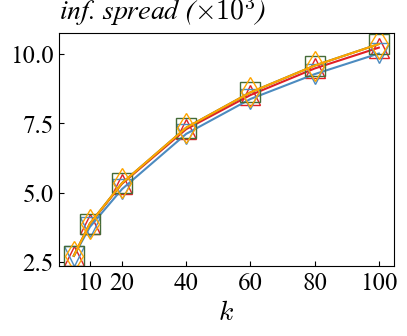

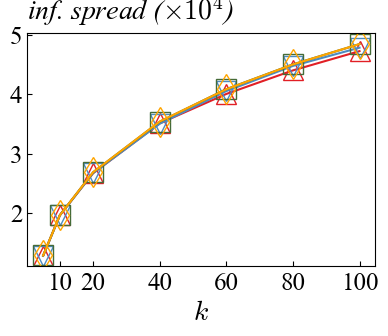

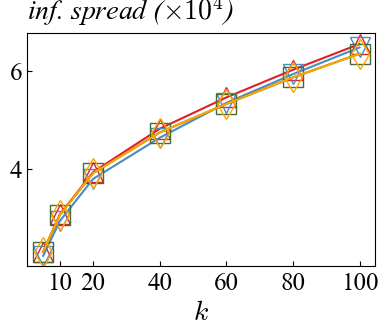

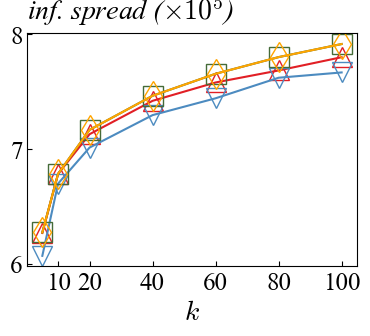

In [7]:
plot_lines(inf_k_Epinions_scale_arr / 1000,
           line_labels=methods_approx+methods_ais,
           x_axis=scale_k_list,
           x_ticks=scale_k_list[1:],
           x_ticklabels=scale_k_list[1:],
           ms=MARKER_SIZE,
           x_label=r"$k$",
           y_label=r"inf. spread ($\times 10^3$)",
           tick_size=TICK_SIZE,
           label_size=LABEL_SIZE,
           fig_size=FIG_SIZE,
           y_label_pos=Y_LABEL_POS,
           save_path="./figs/inf_k_RAND_Epinions_scale.pdf"
           )

plot_lines(inf_k_DBLP_scale_arr / 10000,
           line_labels=methods_approx+methods_ais,
           x_axis=scale_k_list,
           x_ticks=scale_k_list[1:],
           x_ticklabels=scale_k_list[1:],
           ms=MARKER_SIZE,
           x_label=r"$k$",
           y_label=r"inf. spread ($\times 10^4$)",
           tick_size=TICK_SIZE,
           label_size=LABEL_SIZE,
           fig_size=FIG_SIZE,
           y_label_pos=Y_LABEL_POS,
           save_path="./figs/inf_k_RAND_DBLP_scale.pdf"
           )

plot_lines(inf_k_LJ_scale_arr / 10000,
           line_labels=methods_approx+methods_ais,
           x_axis=scale_k_list,
           x_ticks=scale_k_list[1:],
           x_ticklabels=scale_k_list[1:],
           ms=MARKER_SIZE,
           x_label=r"$k$",
           y_label=r"inf. spread ($\times 10^4$)",
           tick_size=TICK_SIZE,
           label_size=LABEL_SIZE,
           fig_size=FIG_SIZE,
           y_label_pos=Y_LABEL_POS,
           save_path="./figs/inf_k_RAND_LJ_scale.pdf"
           )

np.append(np.array([[250.217] for i in range(4)]), inf_k_orkut_scale_arr, axis=1)
plot_lines(inf_k_orkut_scale_arr / 100000,
           line_labels=methods_approx+methods_ais,
           x_axis=scale_k_list,
           x_ticks=scale_k_list[1:],
           x_ticklabels=scale_k_list[1:],
           ms=MARKER_SIZE,
           x_label=r"$k$",
           y_label=r"inf. spread ($\times 10^5$)",
           tick_size=TICK_SIZE,
           label_size=LABEL_SIZE,
           fig_size=FIG_SIZE,
           y_label_pos=Y_LABEL_POS,
           save_path="./figs/inf_k_RAND_orkut_scale.pdf"
           )


# Running Time v.s. $k$

In [18]:
time_k_epin_RAND_dict = get_runtime_for_lines_of_one_dataset("Epinions", list(range(2021, 2031)),
                                                             k_list=scale_k_list,
                                                   baseline_names=methods_approx,
                                                   settings={"eps":0.1, "seed_mode":"RAND"})
time_k_epin_RAND_dict_AIS = get_runtime_for_lines_of_one_dataset("Epinions", list(range(2021, 2031)), 
                                                   baseline_names=methods_ais,
                                                   k_list=scale_k_list,
                                                   settings={"eps":0.1, "seed_mode":"RAND", "num_samples":102400})
time_k_epin_RAND_arr = convert_dict_to_arr({**time_k_epin_RAND_dict, **time_k_epin_RAND_dict_AIS}, all_methods)

time_k_DBLP_RAND_dict = get_runtime_for_lines_of_one_dataset("DBLP", list(range(2021, 2031)),
                                                             k_list=scale_k_list,
                                                   baseline_names=methods_approx,
                                                   settings={"eps":0.1, "seed_mode":"RAND"})
time_k_DBLP_RAND_dict_AIS = get_runtime_for_lines_of_one_dataset("DBLP", list(range(2021, 2031)), 
                                                   baseline_names=methods_ais,
                                                   k_list=scale_k_list,
                                                   settings={"eps":0.1, "seed_mode":"RAND", "num_samples":102400})
time_k_DBLP_RAND_arr = convert_dict_to_arr({**time_k_DBLP_RAND_dict, **time_k_DBLP_RAND_dict_AIS}, all_methods)

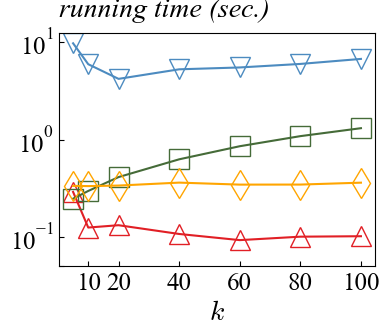

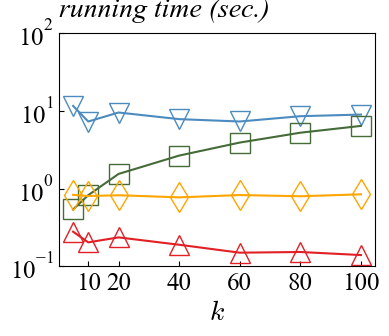

In [23]:
plot_lines(time_k_epin_RAND_arr,
           line_labels=["AISPAC", "AugIM", "AIS", "AIS_plus"],
           x_axis=scale_k_list,
           x_ticks=scale_k_list[1:],
           x_ticklabels=scale_k_list[1:],
           ms=MARKER_SIZE,
           x_label=r"$k$",
           y_label=r"running time (sec.)",
           tick_size=TICK_SIZE,
           label_size=LABEL_SIZE,
           fig_size=FIG_SIZE,
           y_label_pos=Y_LABEL_POS,
           y_logscale=True,
           y_ticks=[0.05, 0.1, 1, 10],
           minor_ticks=False,
           save_path="./figs/time_k_RAND_epin.pdf"
           )
plot_lines(time_k_DBLP_RAND_arr,
           line_labels=["AISPAC", "AugIM", "AIS", "AIS_plus"],
           x_axis=scale_k_list,
           x_ticks=scale_k_list[1:],
           x_ticklabels=scale_k_list[1:],
           ms=MARKER_SIZE,
           x_label=r"$k$",
           y_label=r"running time (sec.)",
           tick_size=TICK_SIZE,
           label_size=LABEL_SIZE,
           fig_size=FIG_SIZE,
           y_label_pos=Y_LABEL_POS,
           y_logscale=True,
           y_ticks=[0.1, 1, 10, 100],
           minor_ticks=False,
           save_path="./figs/time_k_OUTDEG_dblp.pdf"
           )

# Large $k$. Comparison of AIS and AIS+

In [13]:
LARGE_K_LIST=[500, 1000, 1500, 2000]
METHODS=["AIS", "AIS_plus"]
inf_k_epin_aisp_dict = get_inf_spread_of_one_dataset("Epinions", list(range(2021, 2031)),
                                                k_list=[500, 1000, 1500, 2000],
                                                baseline_names=METHODS,
                                                settings={"eps":0.1, "seed_mode":"RAND", "num_samples":102400})
inf_k_epin_aisp_arr = np.array(list(inf_k_epin_aisp_dict.values()))

inf_k_dblp_aisp_dict = get_inf_spread_of_one_dataset("DBLP", list(range(2021, 2031)),
                                                k_list=[500, 1000, 1500, 2000],
                                                baseline_names=METHODS,
                                                settings={"eps":0.1, "seed_mode":"RAND", "num_samples":102400})
inf_k_dblp_aisp_arr = np.array(list(inf_k_dblp_aisp_dict.values()))

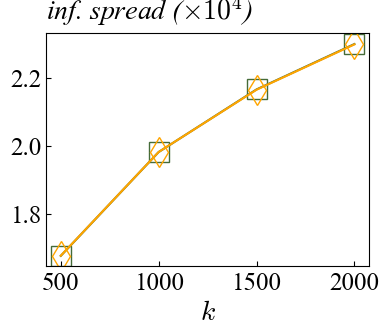

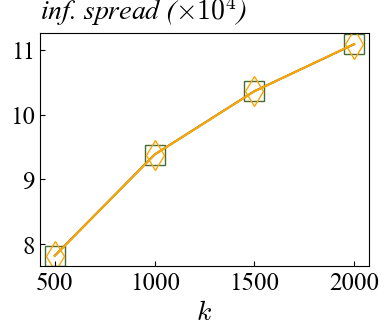

In [14]:
plot_lines(inf_k_epin_aisp_arr / 10000,
           line_labels=METHODS,
           x_axis=[500, 1000, 1500, 2000],
           ms=MARKER_SIZE,
           marker_list=MARKERS_LIST[2:],
           color_list=COLOR_LIST[2:],
           x_label=r"$k$",
           y_label=r"inf. spread ($\times 10^4$)",
           tick_size=TICK_SIZE,
           label_size=LABEL_SIZE,
           fig_size=FIG_SIZE,
           y_label_pos=Y_LABEL_POS,
           save_path="./figs/inf_k_RAND_epin_largeK.pdf"
           )

plot_lines(inf_k_dblp_aisp_arr / 10000,
           line_labels=METHODS,
           x_axis=[500, 1000, 1500, 2000],
           ms=MARKER_SIZE,
           marker_list=MARKERS_LIST[2:],
           color_list=COLOR_LIST[2:],
           x_label=r"$k$",
           y_label=r"inf. spread ($\times 10^4$)",
           tick_size=TICK_SIZE,
           label_size=LABEL_SIZE,
           fig_size=FIG_SIZE,
           y_label_pos=Y_LABEL_POS,
           save_path="./figs/inf_k_RAND_dblp_largeK.pdf"
           )

In [92]:
time_k_epin_aisp = get_runtime_for_lines_of_one_dataset("Epinions", list(range(2021, 2031)), METHODS,
                                                        k_list=[500, 1000, 1500, 2000],
                                                        settings={"eps":0.1, "seed_mode":"RAND", "num_samples":102400})
time_k_epin_aisp_arr = np.array(list(time_k_epin_aisp.values()))
time_k_dblp_aisp = get_runtime_for_lines_of_one_dataset("DBLP", list(range(2021, 2031)), METHODS,
                                                        k_list=[500, 1000, 1500, 2000],
                                                        settings={"eps":0.1, "seed_mode":"RAND", "num_samples":102400})
time_k_dblp_aisp_arr = np.array(list(time_k_dblp_aisp.values()))

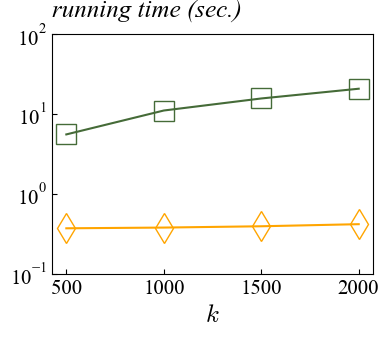

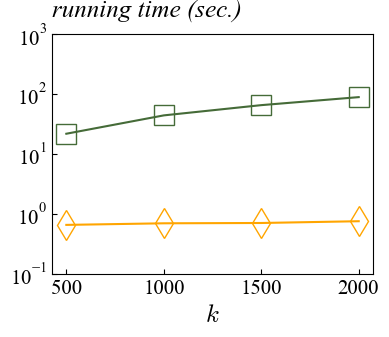

In [94]:
plot_lines(time_k_epin_aisp_arr,
           line_labels=METHODS,
           x_axis=LARGE_K_LIST,
           ms=MARKER_SIZE,
           marker_list=MARKERS_LIST[2:],
           color_list=COLOR_LIST[2:],
           x_label=r"$k$",
           y_label=r"running time (sec.)",
           tick_size=TICK_SIZE,
           label_size=LABEL_SIZE,
           fig_size=FIG_SIZE,
           y_label_pos=Y_LABEL_POS,
           y_logscale=True,
           y_ticks=[0.1, 1, 10, 100],
           minor_ticks=False,
           save_path="./figs/time_k_RAND_epin_largeK.pdf"
           )
plot_lines(time_k_dblp_aisp_arr,
           line_labels=METHODS,
           x_axis=LARGE_K_LIST,
           ms=MARKER_SIZE,
           marker_list=MARKERS_LIST[2:],
           color_list=COLOR_LIST[2:],
           x_label=r"$k$",
           y_label=r"running time (sec.)",
           tick_size=TICK_SIZE,
           label_size=LABEL_SIZE,
           fig_size=FIG_SIZE,
           y_label_pos=Y_LABEL_POS,
           y_logscale=True,
           y_ticks=[0.1, 1, 10, 100, 1000],
           minor_ticks=False,
           save_path="./figs/time_k_RAND_dblp_largeK.pdf"
           )

In [19]:
inf_RRsets_epin_dict = get_inf_numRRsets_of_one_dataset("Epinions", list(range(2021, 2031)), ["AISPAC", "AugIM", "AIS"])
inf_RRsets_epin_list = np.array(list(inf_RRsets_epin_dict.values()))

inf_RRsets_DBLP_dict = get_inf_numRRsets_of_one_dataset("DBLP", list(range(2021, 2032)), ["AISPAC", "AugIM", "AIS"])
inf_RRsets_DBLP_list = np.array(list(inf_RRsets_DBLP_dict.values()))

inf_RRsets_LJ_dict = get_inf_numRRsets_of_one_dataset("LJ", list(range(2021, 2032)), ["AISPAC", "AugIM", "AIS"])
inf_RRsets_LJ_list = np.array(list(inf_RRsets_LJ_dict.values()))

inf_RRsets_orkut_dict = get_inf_numRRsets_of_one_dataset("orkut", RAND_SEEDS, ["AISPAC", "AugIM", "AIS"])
inf_RRsets_orkut_list = np.array(list(inf_RRsets_orkut_dict.values()))

inf_RRsets_twitter_dict = get_inf_numRRsets_of_one_dataset("twitter", RAND_SEEDS, ["AISPAC", "AugIM", "AIS"])
inf_RRsets_twitter_list = np.array(list(inf_RRsets_twitter_dict.values()))

In [18]:
MARKER_SIZE=15
LABEL_SIZE=18
TICK_SIZE=15
FIG_SIZE=[4, 3.5]
plot_lines(inf_RRsets_epin_list / 1000,
           line_labels=["AISPAC", "AugIM", "AIS"],
           x_axis=NUM_RR / 100,
           ms=MARKER_SIZE,
           x_label=r"# of RR sets ($\times 100$)",
           y_label=r"inf. spread ($\times 10^3$)",
           tick_size=TICK_SIZE,
           label_size=LABEL_SIZE,
           fig_size=FIG_SIZE,
           y_label_pos=[-0.1, 1.1],
           x_logscale=True,
           x_logbase=2,
           x_ticks=[2**i for i in range(0, 11)],
           tick_pad=6,
           save_path="./figs/inf_numRR_RAND_epin.pdf"
           )
plot_lines(inf_RRsets_DBLP_list / 10000,
           line_labels=["AISPAC", "AugIM", "AIS"],
           x_axis=NUM_RR / 100,
           ms=MARKER_SIZE,
           x_label=r"# of RR sets ($\times 100$)",
           y_label=r"inf. spread ($\times 10^4$)",
           tick_size=TICK_SIZE,
           label_size=LABEL_SIZE,
           fig_size=FIG_SIZE,
           y_label_pos=[-0.1, 1.1],
           x_logscale=True,
           x_logbase=2,
           x_ticks=[2**i for i in range(0, 11)],
           tick_pad=6,
           save_path="./figs/inf_numRR_RAND_dblp.pdf"
           )
plot_lines(inf_RRsets_LJ_list / 10000,
           line_labels=["AISPAC", "AugIM", "AIS"],
           x_axis=NUM_RR / 100,
           ms=MARKER_SIZE,
           x_label=r"# of RR sets ($\times 100$)",
           y_label=r"inf. spread ($\times 10^4$)",
           tick_size=TICK_SIZE,
           label_size=LABEL_SIZE,
           fig_size=FIG_SIZE,
           y_label_pos=[-0.1, 1.1],
           x_logscale=True,
           x_logbase=2,
           x_ticks=[2**i for i in range(0, 11)],
           tick_pad=6,
           save_path="./figs/inf_numRR_RAND_LJ.pdf"
           )

plot_lines(np.array(inf_RRsets_orkut_list) / 100000,
           line_labels=["AISPAC", "AugIM", "AIS"],
           x_axis=NUM_RR / 100,
           ms=MARKER_SIZE,
           x_label=r"# of RR sets ($\times 100$)",
           y_label=r"inf. spread ($\times 10^5$)",
           tick_size=TICK_SIZE,
           label_size=LABEL_SIZE,
           fig_size=FIG_SIZE,
           y_label_pos=[-0.1, 1.1],
           x_logscale=True,
           x_logbase=2,
           x_ticks=[2**i for i in range(0, 11)],
           tick_pad=6,
           save_path="./figs/inf_numRR_RAND_orkut.pdf"
           )

plot_lines(np.array(inf_RRsets_twitter_list) / 1000000,
           line_labels=["AISPAC", "AugIM", "AIS"],
           x_axis=NUM_RR / 100,
           ms=MARKER_SIZE,
           x_label=r"# of RR sets ($\times 100$)",
           y_label=r"inf. spread ($\times 10^6$)",
           tick_size=TICK_SIZE,
           label_size=LABEL_SIZE,
           fig_size=FIG_SIZE,
           y_label_pos=[-0.1, 1.1],
           x_logscale=True,
           x_logbase=2,
           x_ticks=[2**i for i in range(0, 11)],
           tick_pad=6,
           save_path="./figs/inf_numRR_RAND_twitter.pdf"
           )

AssertionError: 

In [3]:
setting_dict = {
    "k_edges":1,
    "seed_mode":"RAND"
}
inf_RRsets_twitter_k_1_dict = get_inf_numRRsets_of_one_dataset("twitter", RAND_SEEDS, ["AISPAC", "AugIM", "AIS"], settings=setting_dict)
inf_RRsets_twitter_k_1_list = np.array(list(inf_RRsets_twitter_k_1_dict.values()))

setting_dict = {
    "k_edges":10,
    "seed_mode":"RAND"
}
inf_RRsets_twitter_k_10_dict = get_inf_numRRsets_of_one_dataset("twitter", RAND_SEEDS, ["AISPAC", "AugIM", "AIS"], settings=setting_dict)
inf_RRsets_twitter_k_10_list = np.array(list(inf_RRsets_twitter_k_10_dict.values()))

setting_dict = {
    "k_edges":100,
    "seed_mode":"RAND"
}
inf_RRsets_twitter_k_100_dict = get_inf_numRRsets_of_one_dataset("twitter", RAND_SEEDS, ["AISPAC", "AugIM", "AIS"], settings=setting_dict)
inf_RRsets_twitter_k_100_list = np.array(list(inf_RRsets_twitter_k_100_dict.values()))

setting_dict = {
    "k_edges":1000,
    "seed_mode":"RAND"
}
inf_RRsets_twitter_k_1000_dict = get_inf_numRRsets_of_one_dataset("twitter", RAND_SEEDS, ["AISPAC", "AugIM", "AIS_plus"], settings=setting_dict)
inf_RRsets_twitter_k_1000_list = np.array(list(inf_RRsets_twitter_k_1000_dict.values()))

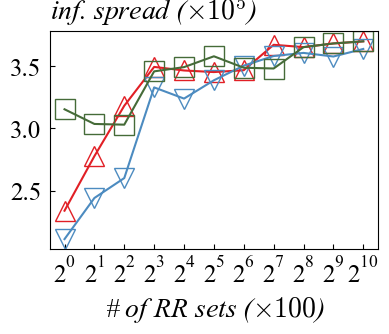

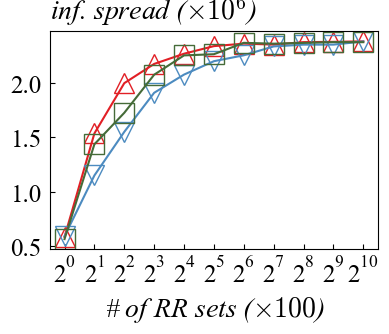

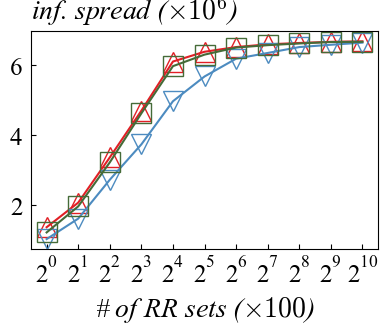

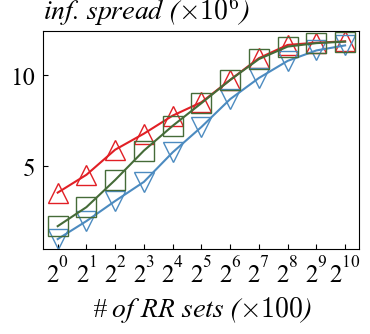

In [4]:
plot_lines(inf_RRsets_twitter_k_1_list / 100000,
           line_labels=["AISPAC", "AugIM", "AIS"],
           x_axis=np.array(NUM_RR) / 100,
           ms=MARKER_SIZE,
           x_label=r"# of RR sets ($\times 100$)",
           y_label=r"inf. spread ($\times 10^5$)",
           tick_size=TICK_SIZE,
           label_size=LABEL_SIZE,
           fig_size=FIG_SIZE,
           y_label_pos=Y_LABEL_POS,
           x_logscale=True,
           x_logbase=2,
           x_ticks=[2**i for i in range(0, 11)],
           tick_pad=6,
           save_path="./figs/inf_numRR_RAND_k_1_twitter.pdf"
           )

plot_lines(inf_RRsets_twitter_k_10_list / 1000000,
           line_labels=["AISPAC", "AugIM", "AIS"],
           x_axis=np.array(NUM_RR) / 100,
           ms=MARKER_SIZE,
           x_label=r"# of RR sets ($\times 100$)",
           y_label=r"inf. spread ($\times 10^6$)",
           tick_size=TICK_SIZE,
           label_size=LABEL_SIZE,
           fig_size=FIG_SIZE,
           y_label_pos=Y_LABEL_POS,
           x_logscale=True,
           x_logbase=2,
           x_ticks=[2**i for i in range(0, 11)],
           tick_pad=6,
           save_path="./figs/inf_numRR_RAND_k_10_twitter.pdf"
           )

plot_lines(inf_RRsets_twitter_k_100_list / 1000000,
           line_labels=["AISPAC", "AugIM", "AIS"],
           x_axis=np.array(NUM_RR) / 100,
           ms=MARKER_SIZE,
           x_label=r"# of RR sets ($\times 100$)",
           y_label=r"inf. spread ($\times 10^6$)",
           tick_size=TICK_SIZE,
           label_size=LABEL_SIZE,
           fig_size=FIG_SIZE,
           y_label_pos=Y_LABEL_POS,
           x_logscale=True,
           x_logbase=2,
           x_ticks=[2**i for i in range(0, 11)],
           tick_pad=6,
           save_path="./figs/inf_numRR_RAND_k_100_twitter.pdf"
           )

plot_lines(inf_RRsets_twitter_k_1000_list / 1000000,
           line_labels=["AISPAC", "AugIM", "AIS"],
           x_axis=np.array(NUM_RR) / 100,
           ms=MARKER_SIZE,
           x_label=r"# of RR sets ($\times 100$)",
           y_label=r"inf. spread ($\times 10^6$)",
           tick_size=TICK_SIZE,
           label_size=LABEL_SIZE,
           fig_size=FIG_SIZE,
           y_label_pos=Y_LABEL_POS,
           x_logscale=True,
           x_logbase=2,
           x_ticks=[2**i for i in range(0, 11)],
           tick_pad=6,
           save_path="./figs/inf_numRR_RAND_k_1000_twitter.pdf"
           )

In [12]:
setting_dict = {
    "seed_mode":"OUTDEG",
    "k_edges":50
}
inf_RRsets_epin_dict = get_inf_numRRsets_of_one_dataset("Epinions", list(range(2021, 2032)), ["AISPAC", "AugIM", "AIS"], settings=setting_dict)
inf_RRsets_epin_list = np.array(list(inf_RRsets_epin_dict.values()))

inf_RRsets_DBLP_dict = get_inf_numRRsets_of_one_dataset("DBLP", list(range(2021, 2032)), ["AISPAC", "AugIM", "AIS"], settings=setting_dict)
inf_RRsets_DBLP_list = np.array(list(inf_RRsets_DBLP_dict.values()))

inf_RRsets_LJ_dict = get_inf_numRRsets_of_one_dataset("LJ", list(range(2021, 2032)), ["AISPAC", "AugIM", "AIS"], settings=setting_dict)
inf_RRsets_LJ_list = np.array(list(inf_RRsets_LJ_dict.values()))

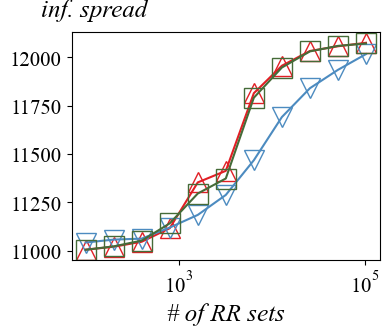

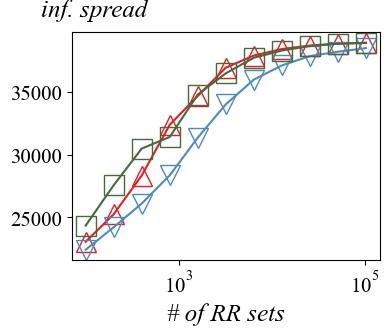

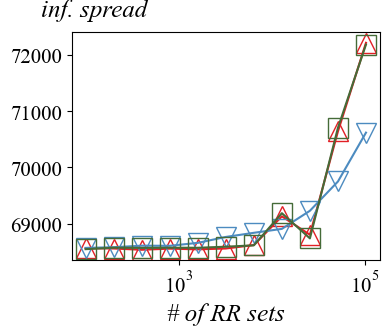

In [14]:
plot_lines(inf_RRsets_epin_list,
           line_labels=["AISPAC", "AugIM", "AIS"],
           x_axis=NUM_RR,
           ms=MARKER_SIZE,
           x_label="# of RR sets",
           y_label="inf. spread",
           tick_size=TICK_SIZE,
           label_size=LABEL_SIZE,
           fig_size=FIG_SIZE,
           y_label_pos=[-0.1, 1.1],
           x_logscale=True,
           save_path="./figs/inf_numRR_OUTDEG_epin.pdf"
           )

plot_lines(inf_RRsets_DBLP_list,
           line_labels=["AISPAC", "AugIM", "AIS"],
           x_axis=NUM_RR,
           ms=MARKER_SIZE,
           x_label="# of RR sets",
           y_label="inf. spread",
           tick_size=TICK_SIZE,
           label_size=LABEL_SIZE,
           fig_size=FIG_SIZE,
           y_label_pos=[-0.1, 1.1],
           x_logscale=True,
           save_path="./figs/inf_numRR_OUTDEG_dblp.pdf"
           )

plot_lines(inf_RRsets_LJ_list,
           line_labels=["AISPAC", "AugIM", "AIS"],
           x_axis=NUM_RR,
           ms=MARKER_SIZE,
           x_label="# of RR sets",
           y_label="inf. spread",
           tick_size=TICK_SIZE,
           label_size=LABEL_SIZE,
           fig_size=FIG_SIZE,
           y_label_pos=[-0.1, 1.1],
           x_logscale=True,
           save_path="./figs/inf_numRR_OUTDEG_LJ.pdf"
           )

## Small Datasets with 10000 candidate edges
### Baseline Methods

In [3]:
# runtime_grqc = get_runtime_of_one_dataset("GRQC", RAND_SEEDS, baseline_names=["IMA"], seed_mode="RAND", num_cand_edges=10000)
# runtime_nethept = get_runtime_of_one_dataset("nethept", rand_seeds_nethept, baseline_names=["IMA"], seed_mode="RAND", num_cand_edges=10000)
runtime_grqc = get_runtime_of_one_dataset("GRQC", RAND_SEEDS, baseline_names=["IMA"], seed_mode="IM", num_cand_edges=10000)
runtime_nethept = get_runtime_of_one_dataset("nethept", rand_seeds_nethept, baseline_names=["IMA"], seed_mode="IM", num_cand_edges=10000)


### MCGreedy data

In [27]:
MCG_time_k_grqc = get_runtime_k_mcg("GRQC", RAND_SEEDS)
MCG_time_k_nethept = get_runtime_k_mcg("nethept", RAND_SEEDS)
runtime_r_GRQC_step2k = get_runtime_r_mcg("GRQC", RAND_SEEDS)
runtime_r_nethept_step2k = get_runtime_r_mcg("nethept", RAND_SEEDS)
runtime_r_GRQC = get_runtime_r_mcg("GRQC", RAND_SEEDS, [i*1000 for i in range(1, 6)])
runtime_r_nethept = get_runtime_r_mcg("nethept", RAND_SEEDS, [i*1000 for i in range(1, 6)])
runtime_r_GRQC_IM = get_runtime_r_mcg("GRQC", RAND_SEEDS, [1000, 2000, 3000, 4000, 5000], "IM")
runtime_r_nethept_IM = get_runtime_r_mcg("nethept", RAND_SEEDS, [1000, 2000, 3000, 4000, 5000], "IM")

In [28]:
display_for_tex(runtime_r_nethept, "MCGreedy", [i for i in range(1, 6)])

(1,304.4098)
(2,326.0024)
(3,404.653)
(4,434.4754)
(5,640.8142)


In [11]:
display_for_tex(runtime_r_nethept_IM, "MCGreedy", [i*1000 for i in range(1,6)])

(1000,1510.126)
(2000,3024.026)
(3000,4641.218)
(4000,6418.404)
(5000,7780.71)


In [27]:
display_for_tex(runtime_nethept, "IMA", K_LIST)

(5,0.0957)
(10,0.3037)
(20,1.0251)
(30,2.2648)
(40,4.0737)
(50,6.259)


In [3]:
inf_beta_nethept = get_inf_beta_of_one_dataset("nethept", rand_seeds_nethept)
inf_beta_epinion = get_inf_beta_of_one_dataset("Epinions", RAND_SEEDS)
inf_beta_dblp = get_inf_beta_of_one_dataset("DBLP", RAND_SEEDS)
inf_beta_orkut = get_inf_beta_of_one_dataset("orkut", RAND_SEEDS)
inf_beta_twitter = get_inf_beta_of_one_dataset("twitter", RAND_SEEDS)

In [4]:
display_for_tex_all(inf_beta_twitter, [i for i in range(len(BETA_LIST))])

IMA:
(0,0.9984)
(1,0.9984)
(2,0.9984)
(3,0.9982)
(4,0.9999)
(5,0.9993)
(6,1.0)


In [1]:
time_beta_nethept = get_time_beta_of_one_dataset("nethept", rand_seeds_nethept)
time_beta_epinion = get_time_beta_of_one_dataset("Epinions", RAND_SEEDS)
time_beta_dblp = get_time_beta_of_one_dataset("DBLP", RAND_SEEDS)
time_beta_orkut = get_time_beta_of_one_dataset("orkut", RAND_SEEDS)
time_beta_twitter = get_time_beta_of_one_dataset("twitter", RAND_SEEDS)

NameError: name 'get_time_beta_of_one_dataset' is not defined

In [ ]:
display_for_tex_all(time_beta_twitter, [i for i in range(len(BETA_LIST))])

IMA:
(0,699.4426)
(1,459.037)
(2,339.8896)
(3,284.2249)
(4,243.919)
(5,224.9127)
(6,222.3034)


## EPSILON

In [4]:
eps_inf_nethept = get_eps_inf_of_one_dataset("nethept", rand_seeds_nethept)
eps_inf_epin = get_eps_inf_of_one_dataset("Epinions", RAND_SEEDS)
eps_inf_dblp = get_eps_inf_of_one_dataset("DBLP", RAND_SEEDS)
eps_inf_orkut = get_eps_inf_of_one_dataset("orkut", RAND_SEEDS)
eps_inf_twitter = get_eps_inf_of_one_dataset("twitter", RAND_SEEDS[:4])

In [5]:
display_for_tex_all(eps_inf_twitter, EPS_LIST)

IMA:
(0.1,1.0)
(0.2,1.0)
(0.3,0.9999)
(0.4,0.9999)
(0.5,0.9998)


In [8]:
eps_time_nethept = get_eps_time_of_one_dataset("nethept", rand_seeds_nethept)
eps_time_epin = get_eps_time_of_one_dataset("Epinions", RAND_SEEDS)
eps_time_dblp = get_eps_time_of_one_dataset("DBLP", RAND_SEEDS)
eps_time_orkut = get_eps_time_of_one_dataset("orkut", RAND_SEEDS)
eps_time_twitter = get_eps_time_of_one_dataset("twitter", RAND_SEEDS)

In [9]:
display_for_tex_all(eps_time_twitter, [0.1, 0.2, 0.3, 0.4, 0.5])

IMA:
(0.1,12171.155)
(0.2,3112.0224)
(0.3,1507.3786)
(0.4,941.1138)
(0.5,699.4426)


In [10]:
display_for_tex_all(eps_inf_nethept, [0.1, 0.2, 0.3, 0.4, 0.5])
display_for_tex_all(eps_inf_epin, [0.1, 0.2, 0.3, 0.4, 0.5])
display_for_tex_all(eps_inf_dblp, [0.1, 0.2, 0.3, 0.4, 0.5])
display_for_tex_all(eps_inf_orkut, [0.1, 0.2, 0.3, 0.4, 0.5])

IMA:
(0.1,0.9997)
(0.2,0.9998)
(0.3,1.0)
(0.4,0.9999)
(0.5,0.9992)
IMA:
(0.1,1.0)
(0.2,0.9999)
(0.3,0.9998)
(0.4,0.9998)
(0.5,1.0)
IMA:
(0.1,0.9999)
(0.2,1.0)
(0.3,0.9999)
(0.4,1.0)
(0.5,0.9997)
IMA:
(0.1,0.9999)
(0.2,0.9999)
(0.3,0.9999)
(0.4,1.0)
(0.5,0.9999)


In [14]:
runtime_nethept = get_runtime_of_one_dataset("nethept", rand_seeds_nethept, baseline_names=BASELINE_NAMES)
runtime_epin = get_runtime_of_one_dataset("Epinions", RAND_SEEDS, baseline_names=BASELINE_NAMES)
runtime_dblp = get_runtime_of_one_dataset("DBLP", RAND_SEEDS, baseline_names=BASELINE_NAMES)
runtime_orkut = get_runtime_of_one_dataset("orkut", RAND_SEEDS, baseline_names=BASELINE_NAMES)
runtime_twitter = get_runtime_of_one_dataset("twitter", RAND_SEEDS, baseline_names=BASELINE_NAMES)

In [15]:
display_for_tex_all(runtime_twitter, [5, 10, 20, 30, 40, 50])

RAND:
(5,9.9884)
(10,11.7806)
(20,16.2521)
(30,19.319)
(40,21.4907)
(50,26.7651)
OUTDEG:
(5,29.7318)
(10,29.9397)
(20,31.1671)
(30,29.7717)
(40,30.6306)
(50,32.1122)
PROB:
(5,52.178)
(10,52.243)
(20,53.6903)
(30,52.2959)
(40,53.2776)
(50,52.6929)
SINF:
(5,22.5067)
(10,52.9484)
(20,146.2096)
(30,271.7037)
(40,447.0782)
(50,641.6552)
UINF:
(5,24.3755)
(10,57.2389)
(20,153.8611)
(30,285.171)
(40,460.8796)
(50,663.262)
AIS-U:
(5,29.7778)
(10,68.4991)
(20,177.9643)
(30,318.9664)
(40,504.696)
(50,734.8698)
IMA:
(5,28.0647)
(10,64.1785)
(20,164.5828)
(30,302.3398)
(40,490.6986)
(50,699.4426)


In [18]:
display_for_tex(runtime_nethept, "IMA", K_LIST)

(5,0.5917)
(10,2.303)
(20,9.3477)
(30,21.0046)
(40,38.5388)
(50,58.8318)


In [12]:
get_runtime_of_one_dataset("DBLP", RAND_SEEDS)

{'SINF': array([ 0.7288724,  1.898564 ,  5.600618 , 11.020008 , 18.549964 ,
        28.136332 ]),
 'UINF': array([ 1.600365 ,  3.6491004,  9.106902 , 16.295694 , 25.62202  ,
        36.99108  ]),
 'AIS-U': array([ 1.801865 ,  4.0509464,  9.903734 , 17.479322 , 27.1619   ,
        38.86684  ]),
 'IMA': array([ 1.818009 ,  4.0850864,  9.97756  , 17.612822 , 27.38072  ,
        39.31004  ])}

In [10]:
res_nethept = get_inf_spread_of_one_dataset("nethept", rand_seeds_nethept)
res_epinions = get_inf_spread_of_one_dataset("Epinions", RAND_SEEDS)
res_dblp = get_inf_spread_of_one_dataset("DBLP", RAND_SEEDS)
# res_orkut = get_inf_spread_of_one_dataset("orkut", RAND_SEEDS)
# res_twitter = get_inf_spread_of_one_dataset("twitter", RAND_SEEDS)

In [11]:
display_for_tex_all(res_epinions)

RAND:
(0,12050.22)
(5,12053.06)
(10,12061.2)
(20,12082.0)
(30,12081.26)
(40,12081.02)
(50,12086.58)
OUTDEG:
(0,12050.22)
(5,12072.62)
(10,12089.4)
(20,12108.36)
(30,12105.86)
(40,12118.3)
(50,12141.26)
PROB:
(0,12050.22)
(5,12059.14)
(10,12068.92)
(20,12096.46)
(30,12102.1)
(40,12105.6)
(50,12110.98)
SINF:
(0,12050.22)
(5,12122.44)
(10,12207.0)
(20,12346.58)
(30,12461.46)
(40,12562.64)
(50,12655.48)
UINF:
(0,12050.22)
(5,12121.82)
(10,12197.16)
(20,12340.28)
(30,12434.8)
(40,12529.92)
(50,12621.9)
AIS-U:
(0,12050.22)
(5,12211.14)
(10,12361.68)
(20,12616.5)
(30,12846.62)
(40,13068.54)
(50,13262.12)
IMA:
(0,12050.22)
(5,12227.24)
(10,12381.96)
(20,12659.82)
(30,12893.82)
(40,13114.1)
(50,13316.74)


# AISPAC prelim results

In [10]:
runtime_epin = get_runtime_of_one_dataset("Epinions", RAND_SEEDS, baseline_names=["IMA", "AISPAC"])
runtime_dblp = get_runtime_of_one_dataset("DBLP", RAND_SEEDS, baseline_names=["IMA", "AISPAC"])

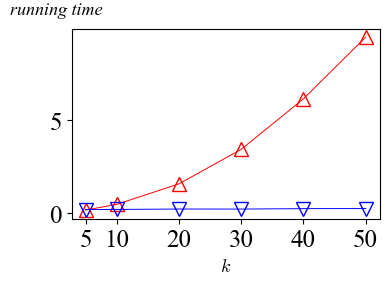

In [19]:
plot_lines([runtime_epin["IMA"], runtime_epin["AISPAC"]],
           line_labels=["IMA", "AISPAC"],
           x_axis=K_LIST,
           x_label=r"$k$",
           y_label="running time",
           save_path="./figs/time_k_epin.pdf",
           tick_size=18,
           ms=10)

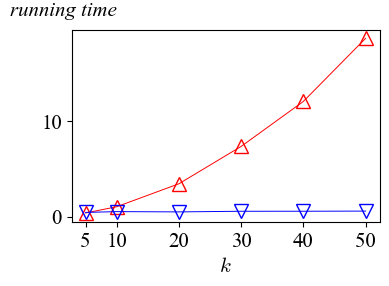

In [22]:
plot_lines([runtime_dblp["IMA"], runtime_dblp["AISPAC"]],
           line_labels=["IMA", "AISPAC"],
           x_axis=K_LIST,
           x_label=r"$k$",
           y_label="running time",
           save_path="./figs/time_k_dblp.pdf",
           tick_size=15,
           label_size=15,
           ms=10)

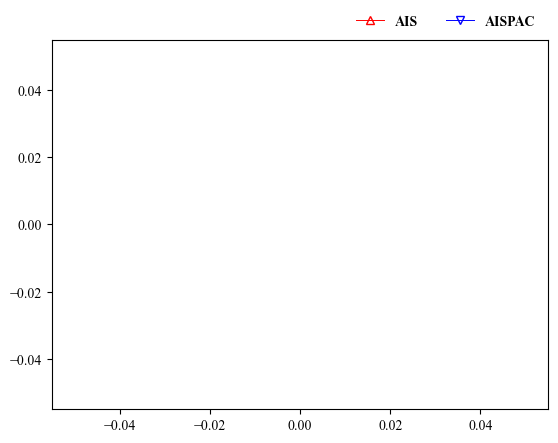

In [13]:
export_legend_for_labels(MARKERS_LIST, COLOR_LIST, ["AIS", "AISPAC", ], output_file="./figs/legend.pdf")

In [14]:
def plot_lines(arr_2d, line_labels, x_axis,
               save_path=None,
               marker_list=MARKERS_LIST,
               color_list=COLOR_LIST,
               ms=5,
               x_logscale=False,
               y_logscale=False,
               **kwargs):
    assert len(line_labels) >= len(arr_2d)
    if "fig_size" in kwargs.keys():
        plt.figure(figsize=kwargs["fig_size"])    
    else:
        plt.figure(figsize=(4, 3))
    axes = plt.gca()
    for i in range(len(arr_2d)):
        plt.plot(
            x_axis[:len(arr_2d[i])],
            arr_2d[i],
            marker=marker_list[i],
            color=color_list[i],
            fillstyle="none",
            linewidth=LINE_WIDTH,
            label=line_labels[i],
            markersize=ms
        )
    plt.xticks(x_axis)
    if "tick_size" in kwargs.keys():
        # axes.set_xticks(x_axis, fontsize=kwargs["tick_size"])
        # axes.set_yticks(fontsize=kwargs["tick_size"])
        axes.tick_params(labelsize=kwargs["tick_size"])
    if "x_ticks" in kwargs.keys():
        axes.set_xticklabels(kwargs["x_ticks"])
    if "y_ticks" in kwargs.keys():
        axes.set_yticklabels(kwargs["y_ticks"])
    if "x_label" in kwargs.keys():
        plt.xlabel(kwargs["x_label"],
                   fontstyle="italic",
                   fontsize=13)
    if "y_label" in kwargs.keys():
        plt.ylabel(kwargs["y_label"],
                   fontsize=13,
                   fontstyle="italic",
                   labelpad=20,
                   rotation=0,
                   ha='left', va='center'
                   )
        axes.yaxis.set_label_coords(-0.2, 1.1)
    
    if "y_label_pos" in kwargs.keys():
        axes.yaxis.set_label_coords(kwargs["y_label_pos"][0], kwargs["y_label_pos"][1])
    
    if "label_size" in kwargs.keys():
        axes.yaxis.label.set_size(kwargs["label_size"])
        axes.xaxis.label.set_size(kwargs["label_size"])
        
    if x_logscale:
        axes.set_xscale("log")
    if y_logscale:
        axes.set_yscale("log")
    if "title" in kwargs.keys():
        plt.title(kwargs["title"])
    
    if "display_legend" in kwargs.keys() and kwargs["display_legend"]:
        plt.legend()
    plt.tight_layout()
    if save_path != None:
        dir = os.path.split(save_path)[0]
        os.makedirs(dir, exist_ok=True)
        plt.savefig(save_path)
    plt.show()
    return

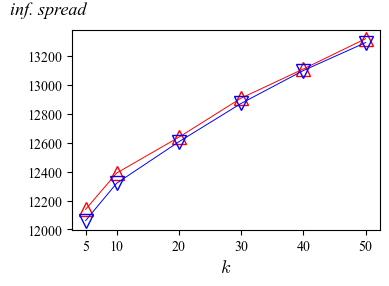

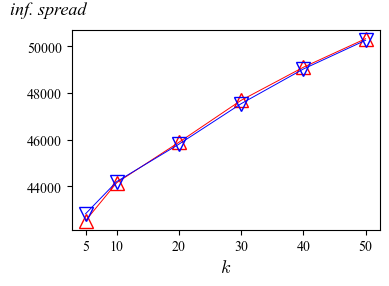

In [15]:
plot_lines([get_inf_from_csv_one_method("Epinions", "IMA"), get_inf_from_csv_one_method("Epinions", "AISPAC")],
           line_labels=["AIS", "AISPAC"],
           x_axis=[5, 10, 20, 30, 40, 50],
           ms=10,
           x_label=r"$k$",
           y_label="inf. spread",
           fig_size=[4, 3],
           save_path="./figs/inf_k_epin.pdf")
plot_lines([get_inf_from_csv_one_method("DBLP", "IMA"), get_inf_from_csv_one_method("DBLP", "AISPAC")],
           line_labels=["AIS", "AISPAC"],
           x_axis=[5, 10, 20, 30, 40, 50],
           ms=10,
           x_label=r"$k$",
           y_label="inf. spread",
           fig_size=[4, 3],
           save_path="./figs/inf_k_dblp.pdf")

In [35]:
def export_legend_for_labels(marker_list,
                             color_list,
                             label_list,
                             output_file="legend.pdf"):
    f = lambda m,c: plt.plot([],[],marker=m, color=c, fillstyle="none", linewidth=LINE_WIDTH)[0]
    handles = [f(marker_list[i], color_list[i]) for i in range(8)]
    legend_font = {"family" : "monospace",
                # "weight": "bold"
                }
    legend = plt.legend(handles,
                        label_list,
                        bbox_to_anchor=(1, 1.1),
                        # loc='best',
                        ncol=9,
                        framealpha=1,
                        frameon=False, 
                        prop=legend_font
                        )

    export_legend(legend, output_file)
    # plt.legend().remove()
    plt.show()
    return

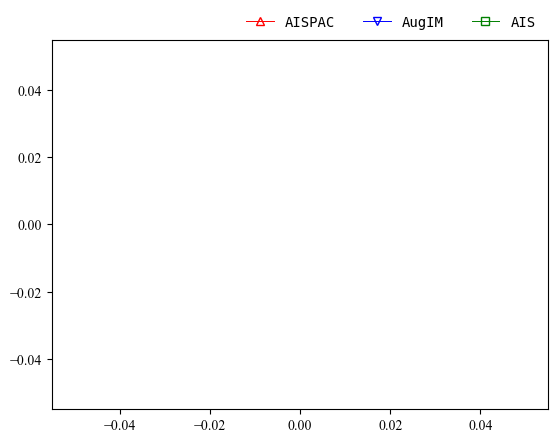

In [36]:
export_legend_for_labels(MARKERS_LIST, COLOR_LIST, ["AISPAC", "AugIM", "AIS"], "./figs/legend.pdf")